In [6]:
import csv
import os
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from biosppy import signals
from scipy.signal import correlate
from scipy.spatial.distance import squareform, pdist
from skimage.transform import resize

In [7]:
folder = "/Users/weijithwimalasiri/Desktop/JustForFun/mimic_perform_af_csv 2"

ecg_file = os.path.join(folder, "ecg_001_data.txt")
file = "mimic_perform_af_001_data.csv"
with open(f"{folder}/{file}", "r") as f:
    reader = csv.reader(f)
    header = next(reader)  # Skip the header row
    with open(ecg_file, "w") as ecg_f:  # Open the ECG file for writing
        for row in reader:
            ecg_f.write(f"{row[2]}\n")  # Process each row as needed

with open(ecg_file, "r") as f:
    ecg_data = f.readlines()

# Process ECG data
print(f"Read {len(ecg_data)} lines of ECG data")
print(f"First 5 ECG values: {ecg_data[:5]}")

Read 150001 lines of ECG data
First 5 ECG values: ['0.42578125\n', '0.404296875\n', '0.400390625\n', '0.400390625\n', '0.419921875\n']


Read 3750 lines of PPG data


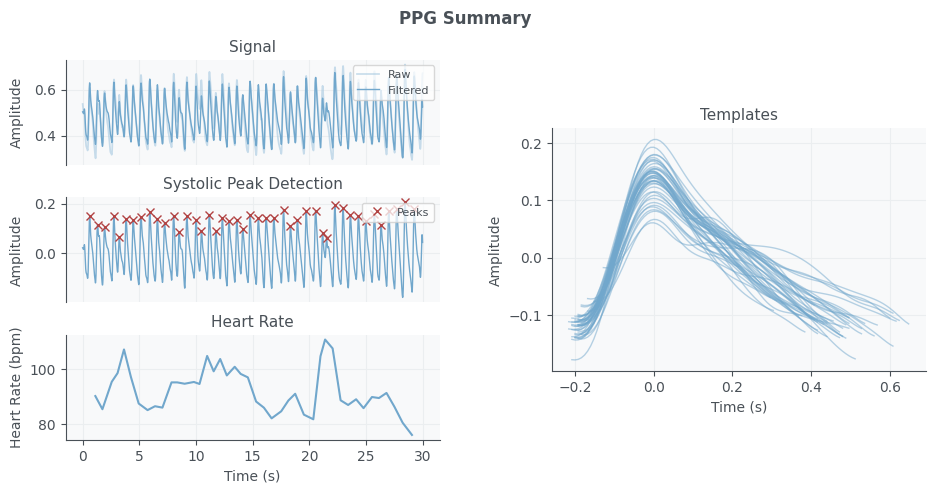

PPG Peaks: [  78  165  242  345  404  479  557  644  740  825  904 1004 1064 1150
 1251 1310 1397 1470 1541 1614 1701 1766 1846 1938 2024 2108 2216 2292
 2369 2466 2570 2646 2690 2782 2872 2953 3042 3123 3217 3291 3376 3464
 3555 3657]
Length of PPI: 43
PPG Inter-peak intervals (ms): [696. 616. 824. 472. 600.]


In [11]:
folder = "/Users/weijithwimalasiri/Desktop/JustForFun/mimic_perform_af_csv 2"
ppg_file = os.path.join(folder, "ppg_001_data.txt")
with open(ppg_file, "r") as f:
    ppg_data = f.readlines()
ppg_data = [float(x.strip()) for x in ppg_data if x.strip()]  

ppg_data = ppg_data[:3750]
print(f"Read {len(ppg_data)} lines of PPG data")
out = signals.ppg.ppg(signal=ppg_data, sampling_rate=125, show=True)
# If you need the peaks, use:
peaks = out['peaks']

ppi = np.diff(peaks)/125 * 1000  # Convert to milliseconds
print(f"PPG Peaks: {peaks}")
print(f"Length of PPI: {len(ppi)}")
print(f"PPG Inter-peak intervals (ms): {ppi[:5]}")

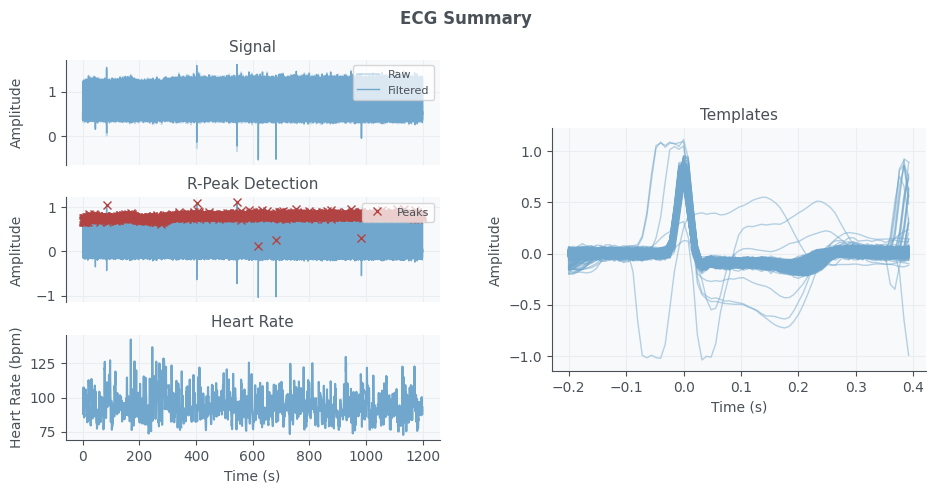

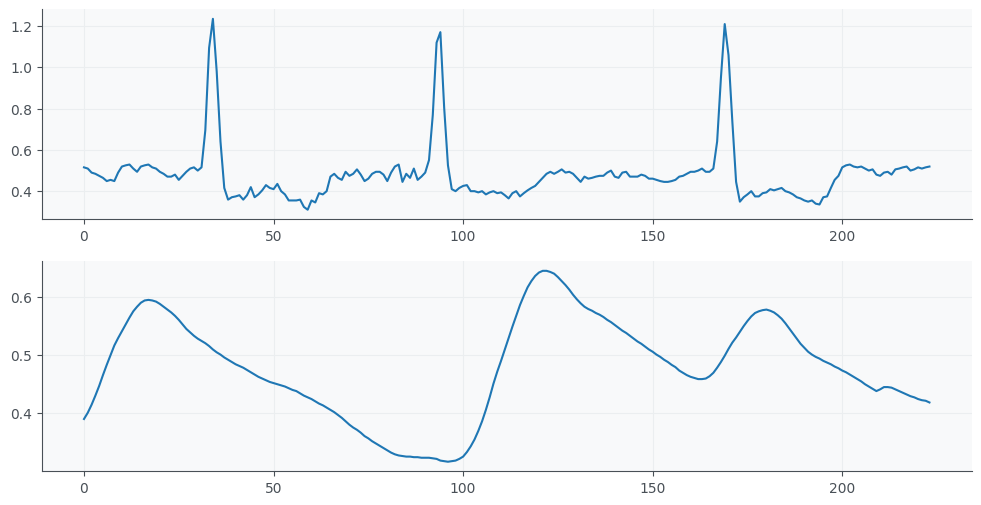

ECG R-peaks: [    76    154    258 ... 149754 149845 149928]
ECG R-R intervals (ms): [624. 832. 480. 600. 616.]
50 50


In [ ]:
ecg_file = os.path.join(folder, "ecg_001_data.txt")
rri_file = os.path.join(folder, "rri_001_data.txt")
with open(ecg_file, "r") as f:
    ecg_data = f.readlines()
ecg_data = [float(x.strip()) for x in ecg_data if x.strip()]
out = signals.ecg.ecg(signal=ecg_data, sampling_rate=125, show= True)
rpeaks = out['rpeaks']

sub_ecg_data = ecg_data[224:448]  # Adjusted to match the PPG data length
sub_ppg_data = ppg_data[224:448]  # Adjusted to match the ECG data length
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(sub_ecg_data, label='ECG Signal')
plt.subplot(2, 1, 2)
plt.plot(sub_ppg_data, label='PPG Signal')
plt.show()
rri = np.diff(rpeaks)/125 * 1000  # Convert to miliseconds
with open(rri_file, "w") as f:
    for r in rri:
        f.write(f"{r}\n")
print(f"ECG R-peaks: {rpeaks}")
print(f"ECG R-R intervals (ms): {rri[:5]}")
first_10_ppi = ppi[:50]
first_10_rri = rri[:50]
print(len(first_10_ppi), len(first_10_rri))

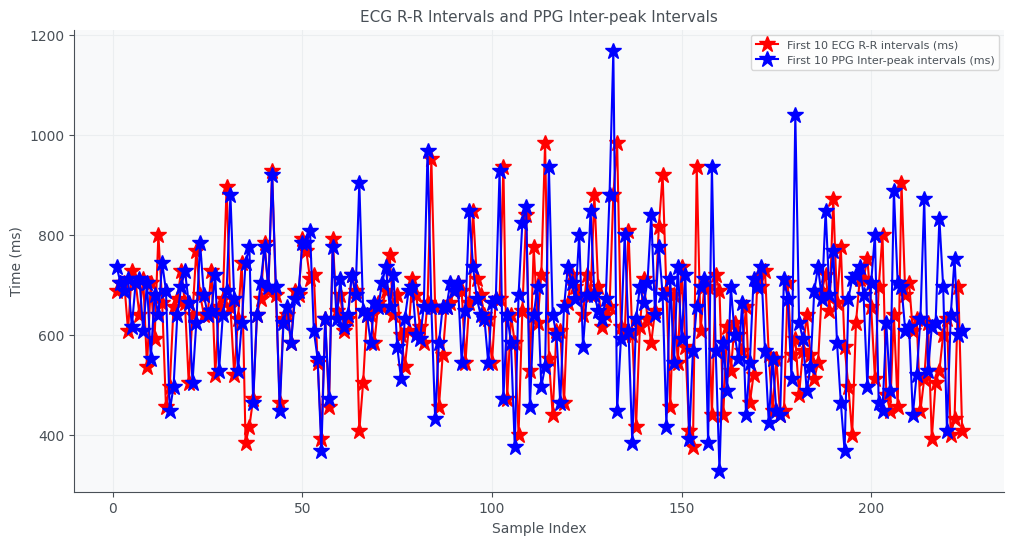

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1,101), first_10_rri[0:100], 'r*-', markersize=12, label='First 10 ECG R-R intervals (ms)')
plt.plot(range(1,101), first_10_ppi[0:100], 'b*-', markersize=12, label='First 10 PPG Inter-peak intervals (ms)')
plt.legend()
plt.title("ECG R-R Intervals and PPG Inter-peak Intervals")
plt.xlabel("Sample Index")
plt.ylabel("Time (ms)")
plt.show()

In [86]:
def normalize_to_gray_scale(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    normalized_matrix = (matrix - min_val) / (max_val - min_val + 1e-8)  # Avoid division by zero
    return (normalized_matrix*255).astype(np.uint8)

In [87]:
def rp_plot(rri, delay, embedding_dim):
    N= len(rri)
    Nrp = N - (embedding_dim - 1) * delay
    embedded_rri = np.array([rri[i: i + embedding_dim * delay: delay] for i in range(Nrp)])
    distances = squareform(pdist(embedded_rri, metric='euclidean'))
    return distances

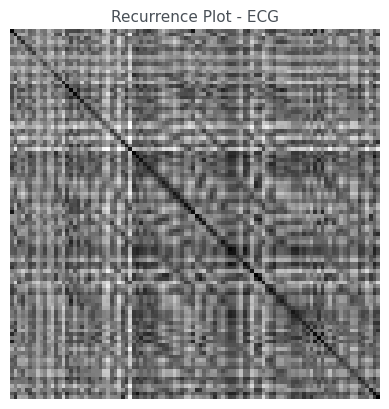

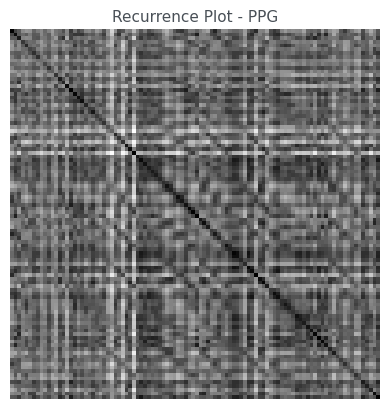

In [93]:
img_dim = (100, 100)
# print(rri[120:170])
distances_rri = rp_plot(rri[0:100], delay= 3, embedding_dim=3)
distances_ppi = rp_plot(ppi[0:100], delay= 3, embedding_dim=3)
rp_gray_rri = normalize_to_gray_scale(distances_rri)
rp_gray_ppi = normalize_to_gray_scale(distances_ppi)
rp_img_rri = resize(rp_gray_rri, img_dim, anti_aliasing=True, preserve_range=True).astype(np.uint8)
rp_img_ppi = resize(rp_gray_ppi, img_dim, anti_aliasing=True, preserve_range=True).astype(np.uint8)

plt.imshow(rp_img_rri, cmap='gray')
plt.axis('off')
plt.title("Recurrence Plot - ECG")
plt.show()

plt.imshow(rp_img_ppi, cmap='gray')
plt.axis('off')
plt.title("Recurrence Plot - PPG")
plt.show()

In [56]:
correlation = correlate(rri, ppi)
lag = np.argmax(correlation) - (len(ppi) - 1)
print(f"Lag between ECG and PPG: {lag} samples")

Lag between ECG and PPG: 4 samples


In [70]:
# min_len = min(len(rri), len(ppi))
r, p_value = pearsonr( ppi[100:201], rri[99:200])
print(f"Pearson correlation: {r}, p-value: {p_value}")

Pearson correlation: 0.33447555292960374, p-value: 0.0006294072325671785


Mean of differences: 1.6
Standard deviation of differences: 11.200000000000001


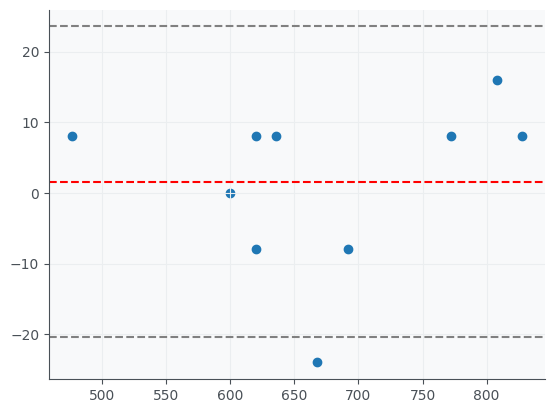

In [66]:
mean = (rri[:10] + ppi[1:11]) / 2
diff = rri[:10] - ppi[1:11]

print(f"Mean of differences: {np.mean(diff)}")
print(f"Standard deviation of differences: {np.std(diff)}")
plt.scatter(mean, diff)
plt.axhline(np.mean(diff), color='red', linestyle='--')
plt.axhline(np.mean(diff) + 1.96*np.std(diff), color='gray', linestyle='--')
plt.axhline(np.mean(diff) - 1.96*np.std(diff), color='gray', linestyle='--')